# 빅데이터 분석 특강 (13주차) 5월30일

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [Special Topics in Big Data Analysis, tensorboard]

### imports 

In [1]:
import numpy as np
import tensorflow as tf 
import tensorflow.experimental.numpy as tnp 

In [2]:
tnp.experimental_enable_numpy_behavior()

In [3]:
import matplotlib.pyplot as plt 

In [4]:
%load_ext tensorboard

### 오버피팅 

#### 오버피팅으로 착각하기 쉬운 상황

`3-(1)` 아래와 같은 모형을 고려하자. 

$$y_i= \beta_0 + \sum_{k=1}^{5} \beta_k \cos(k t_i)+\epsilon_i$$

여기에서 $t=(t_1,\dots,t_{1000})=$ `np.linspace(0,5,1000)` 이다. 그리고 $\epsilon_i \sim i.i.d~ N(0,\sigma^2)$, 즉 서로 독립인 표준정규분포에서 추출된 샘플이다. 위의 모형에서 아래와 같은 데이터를 관측했다고 가정하자. 

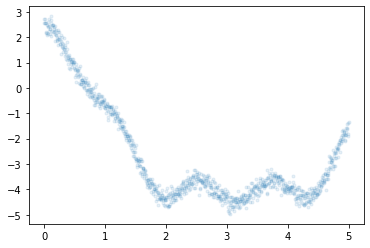

In [5]:
np.random.seed(43052)
t= np.linspace(0,5,1000)
y = -2+ 3*np.cos(t) + 1*np.cos(2*t) + 0.5*np.cos(5*t) + np.random.randn(1000)*0.2
plt.plot(t,y,'.',alpha=0.1)

tf.keras를 이용하여 $\beta_0,\dots,\beta_5$를 추정하라. ($\beta_0,\dots,\beta_5$의 참값은 각각 -2,3,1,0,0,0.5 이다) 

위는 중간고사 문제를 조금 변형한 것!

**(풀이)**

`-` 다시 풀어보자 

In [6]:
y = y.reshape(1000,1)
x1 = np.cos(t) 
x2 = np.cos(2*t)
x3 = np.cos(3*t)
x4 = np.cos(4*t)
x5 = np.cos(5*t)
X = tf.stack([x1,x2,x3,x4,x5],axis=1)

2022-05-30 22:38:45.674545: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-30 22:38:46.134006: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


In [7]:
#collapse_output
!rm -rf logs
net = tf.keras.Sequential()
net.add(tf.keras.layers.Dense(1)) 
net.compile(loss='mse',optimizer='adam')
net.fit(X,y,epochs=500,batch_size=100, validation_split=0.45, callbacks=tf.keras.callbacks.TensorBoard()) 
# 텐서보드를 이용한 시각화기능 추가 
# validation_split 이용

Epoch 1/500
6/6 [==============================] - 1s 17ms/step - loss: 5.6708 - val_loss: 10.4023
Epoch 2/500
6/6 [==============================] - 0s 6ms/step - loss: 5.6196 - val_loss: 10.3534
Epoch 3/500
6/6 [==============================] - 0s 8ms/step - loss: 5.5700 - val_loss: 10.3049
Epoch 4/500
6/6 [==============================] - 0s 9ms/step - loss: 5.5202 - val_loss: 10.2567
Epoch 5/500
6/6 [==============================] - 0s 9ms/step - loss: 5.4700 - val_loss: 10.2094
Epoch 6/500
6/6 [==============================] - 0s 12ms/step - loss: 5.4204 - val_loss: 10.1622
Epoch 7/500
6/6 [==============================] - 0s 12ms/step - loss: 5.3722 - val_loss: 10.1154
Epoch 8/500
6/6 [==============================] - 0s 12ms/step - loss: 5.3235 - val_loss: 10.0689
Epoch 9/500
6/6 [==============================] - 0s 10ms/step - loss: 5.2748 - val_loss: 10.0228
Epoch 10/500
6/6 [==============================] - 0s 11ms/step - loss: 5.2273 - val_loss: 9.9774
Epoch 11/500
6

validation을 0.5로 잡으면 순서대로 250개까지만 모델로 잡고 학습을 시킨 것이라 아래오 같이 그 이후 validation은 맞지 않는 모습.

`-` 결과시각화 

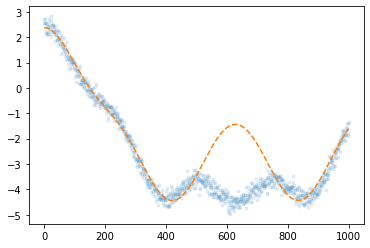

In [8]:
plt.plot(y,'.',alpha=0.1)
plt.plot(net(X),'--')

`-` 보여준 데이터에서는 잘 맞추는것 같지만 validation에서는 엉망이다. -> 오버피팅인가? -> 텐서보드로 확인

In [10]:
# 
%tensorboard --logdir logs --host 0.0.0.0 

Reusing TensorBoard on port 6006 (pid 866653), started 0:00:04 ago. (Use '!kill 866653' to kill it.)

- 확인결과: 에폭마다 val_loss 가 줄어들고 있기는 하다 (늦게 줄어들뿐) -> 오버피팅이라기보다 val_set에 들어있는 자료를 예측하기에는 보여준 데이터가 불충분하다라고 해석하는것이 더 옳음 (모형자체의 문제는 아님)

`-` 해결하는 방법? 그냥 더 학습시키면된다. 

In [12]:
#collapse_output
!rm -rf logs
net = tf.keras.Sequential()
net.add(tf.keras.layers.Dense(1)) 
net.compile(loss='mse',optimizer='adam')
net.fit(X,y,epochs=2000,batch_size=100, validation_split=0.45, callbacks=tf.keras.callbacks.TensorBoard()) 
# 텐서보드를 이용한 시각화기능 추가 
# validation_split 이용

Epoch 1/2000
6/6 [==============================] - 0s 19ms/step - loss: 10.9811 - val_loss: 14.5510
Epoch 2/2000
6/6 [==============================] - 0s 9ms/step - loss: 10.9055 - val_loss: 14.4683
Epoch 3/2000
6/6 [==============================] - 0s 9ms/step - loss: 10.8326 - val_loss: 14.3857
Epoch 4/2000
6/6 [==============================] - 0s 7ms/step - loss: 10.7593 - val_loss: 14.3030
Epoch 5/2000
6/6 [==============================] - 0s 10ms/step - loss: 10.6868 - val_loss: 14.2212
Epoch 6/2000
6/6 [==============================] - 0s 10ms/step - loss: 10.6155 - val_loss: 14.1401
Epoch 7/2000
6/6 [==============================] - 0s 10ms/step - loss: 10.5424 - val_loss: 14.0606
Epoch 8/2000
6/6 [==============================] - 0s 9ms/step - loss: 10.4729 - val_loss: 13.9808
Epoch 9/2000
6/6 [==============================] - 0s 10ms/step - loss: 10.3995 - val_loss: 13.9025
Epoch 10/2000
6/6 [==============================] - 0s 9ms/step - loss: 10.3328 - val_loss: 13

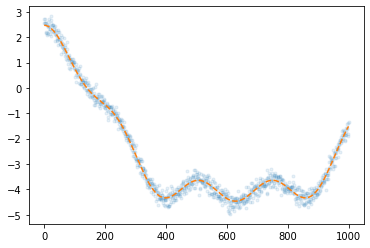

In [13]:
plt.plot(y,'.',alpha=0.1)
plt.plot(net(X),'--')

In [15]:
# 
%tensorboard --logdir logs --host 0.0.0.0 

Reusing TensorBoard on port 6006 (pid 928834), started 0:00:40 ago. (Use '!kill 928834' to kill it.)

- 이런것은 오버핏이 아님!

더 잘 맞추고 있잖아???

오버핏 정의할때 loss가 내려갔다가 올라갔는데 그런 경우도 아니고 심지어 더 빨리 줄어들음

오버핏 함부로 정의하고 dropou 하거나 하지 말자

`-` 결론적으로 말해서 위와 같은 net는 설계하였을 경우 val을 빼는 것은 어리석음. (데이터만 버리는 꼴임)

`-` 더 많은 데이터를 남겨주면 더 빨리 학습한다. 

In [17]:
#collapse_output
!rm -rf logs
net = tf.keras.Sequential()
net.add(tf.keras.layers.Dense(1)) 
net.compile(loss='mse',optimizer='adam')
net.fit(X,y,epochs=500,batch_size=100, validation_split=0.1, callbacks=tf.keras.callbacks.TensorBoard()) 

Epoch 1/500
9/9 [==============================] - 0s 9ms/step - loss: 11.6911 - val_loss: 7.8742
Epoch 2/500
9/9 [==============================] - 0s 6ms/step - loss: 11.5789 - val_loss: 7.8183
Epoch 3/500
9/9 [==============================] - 0s 6ms/step - loss: 11.4716 - val_loss: 7.7619
Epoch 4/500
9/9 [==============================] - 0s 5ms/step - loss: 11.3628 - val_loss: 7.7049
Epoch 5/500
9/9 [==============================] - 0s 5ms/step - loss: 11.2555 - val_loss: 7.6510
Epoch 6/500
9/9 [==============================] - 0s 6ms/step - loss: 11.1457 - val_loss: 7.5974
Epoch 7/500
9/9 [==============================] - 0s 6ms/step - loss: 11.0442 - val_loss: 7.5423
Epoch 8/500
9/9 [==============================] - 0s 5ms/step - loss: 10.9377 - val_loss: 7.4881
Epoch 9/500
9/9 [==============================] - 0s 6ms/step - loss: 10.8357 - val_loss: 7.4360
Epoch 10/500
9/9 [==============================] - 0s 7ms/step - loss: 10.7325 - val_loss: 7.3822
Epoch 11/500
9/9 [=

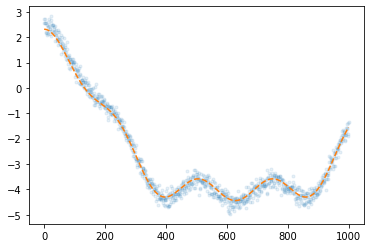

In [18]:
plt.plot(y,'.',alpha=0.1)
plt.plot(net(X),'--')

In [21]:
#
%tensorboard --logdir logs --host 0.0.0.0 

Reusing TensorBoard on port 6006 (pid 944502), started 0:00:02 ago. (Use '!kill 944502' to kill it.)

exponential하게 loss 그래프가 줄어들고 있네

#### 텐서보드: 적합결과 시각화

`-` 시각화결과는 모두 텐서보드에서 보고 싶다! 적합결과를 보여주는 fig 오브젝트를 텐서보드에 끼워넣어서 출력하는 방법을 알아보자.

In [40]:
#collapse_output
!rm -rf logs
net = tf.keras.Sequential()
net.add(tf.keras.layers.Dense(1)) 
net.compile(loss='mse',optimizer='adam')
net.fit(X,y,epochs=500,batch_size=100, validation_split=0.1, callbacks=tf.keras.callbacks.TensorBoard()) 

Epoch 1/500
9/9 [==============================] - 0s 13ms/step - loss: 12.7528 - val_loss: 6.8452
Epoch 2/500
9/9 [==============================] - 0s 3ms/step - loss: 12.6545 - val_loss: 6.8029
Epoch 3/500
9/9 [==============================] - 0s 3ms/step - loss: 12.5574 - val_loss: 6.7638
Epoch 4/500
9/9 [==============================] - 0s 3ms/step - loss: 12.4594 - val_loss: 6.7209
Epoch 5/500
9/9 [==============================] - 0s 3ms/step - loss: 12.3643 - val_loss: 6.6816
Epoch 6/500
9/9 [==============================] - 0s 5ms/step - loss: 12.2691 - val_loss: 6.6395
Epoch 7/500
9/9 [==============================] - 0s 5ms/step - loss: 12.1746 - val_loss: 6.5993
Epoch 8/500
9/9 [==============================] - 0s 5ms/step - loss: 12.0798 - val_loss: 6.5560
Epoch 9/500
9/9 [==============================] - 0s 6ms/step - loss: 11.9885 - val_loss: 6.5155
Epoch 10/500
9/9 [==============================] - 0s 4ms/step - loss: 11.8958 - val_loss: 6.4790
Epoch 11/500
9/9 [

In [25]:
#
%tensorboard --logdir logs --host 0.0.0.0 

Reusing TensorBoard on port 6006 (pid 960141), started 0:00:00 ago. (Use '!kill 960141' to kill it.)

`-` fig 끼워넣을 오브젝트 만들기

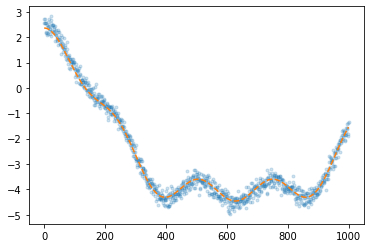

In [27]:
fig, ax = plt.subplots() 
ax.plot(y,'.',alpha=0.2)
ax.plot(net(X),'--')

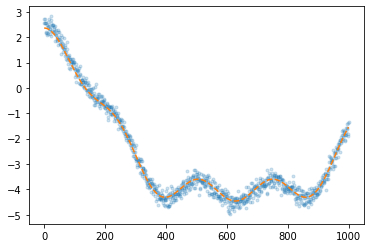

In [28]:
fig

`-` 이제 fig 오브젝트를 끼워넣을 코드를 구성하자. (공식홈페이지 참고)

- https://www.tensorflow.org/tensorboard/image_summaries

In [9]:
# 이코드는 한번만 실행
#from datetime import datetime
import io
logdir = "logs" # logs라는 디렉토리에 추가를 하겠다.
#logdir = "logs" + datetime.now().strftime("%Y%m%d-%H%M%S") 현재시간이랑 logs랑 더해서 값을 string으로 반환, 이게 내가 저장할 디렉토리라고 생각하면 된다.

def plot_to_image(fig): # 사용자가 지정한 그림오브젝트 fig를 넣으면 텐서보드에 끼워넣을수 있는 형태로 출력해주는 함수 
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(fig)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

In [10]:
with tf.summary.create_file_writer(logdir).as_default():
    tf.summary.image("적합결과시각화", plot_to_image(fig), step=0)

위에서 디렉토리를 지정해주면 아래 코드에서 logs에 지정한 디렉토리 이름을 입력해주면 사진만 나옴

위에는 시간이 필요할때 사용해주면 될 것 같다.

In [44]:
#
%tensorboard --logdir logs --host 0.0.0.0

Reusing TensorBoard on port 6006 (pid 975925), started 0:00:07 ago. (Use '!kill 975925' to kill it.)

### 학습과정분석

학습이 어떻게 진행되고 있는가?

#### 텐서보드: 가중치 시각화

`-` 에폭별로 가중치가 수렴하는 모양을 보고 싶다.

`3-(1)` 아래와 같은 모형을 고려하자. 

$$y_i= \beta_0 + \sum_{k=1}^{5} \beta_k \cos(k t_i)+\epsilon_i$$

여기에서 $t=(t_1,\dots,t_{1000})=$ `np.linspace(0,5,1000)` 이다. 그리고 $\epsilon_i \sim i.i.d~ N(0,\sigma^2)$, 즉 서로 독립인 표준정규분포에서 추출된 샘플이다. 위의 모형에서 아래와 같은 데이터를 관측했다고 가정하자. 

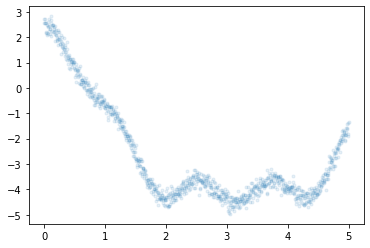

In [46]:
np.random.seed(43052)
t= np.linspace(0,5,1000)
y = -2+ 3*np.cos(t) + 1*np.cos(2*t) + 0.5*np.cos(5*t) + np.random.randn(1000)*0.2
plt.plot(t,y,'.',alpha=0.1)

`-` 학습을 진행하면서 가중치가 어떻게 업데이트 되는지 시각화하자.

여기서 가중치는 베타0,1,2,3,4,5를 의미한다.

In [47]:
# y = -2+ 3*np.cos(t) + 1*np.cos(2*t) + 0.5*np.cos(5*t) + np.random.randn(1000)*0.2

In [79]:
#collapse_output

!rm -rf logs
net = tf.keras.Sequential()
net.add(tf.keras.layers.Dense(1))
net.compile(loss='mse',optimizer='adam')
cb1= tf.keras.callbacks.TensorBoard(update_freq='epoch',histogram_freq=10)
net.fit(X,y,epochs=2000, batch_size=100, validation_split=0.45,callbacks=cb1)

Epoch 1/2000
6/6 [==============================] - 0s 18ms/step - loss: 7.1756 - val_loss: 14.1942
Epoch 2/2000
6/6 [==============================] - 0s 5ms/step - loss: 7.1239 - val_loss: 14.1148
Epoch 3/2000
6/6 [==============================] - 0s 8ms/step - loss: 7.0733 - val_loss: 14.0384
Epoch 4/2000
6/6 [==============================] - 0s 9ms/step - loss: 7.0227 - val_loss: 13.9609
Epoch 5/2000
6/6 [==============================] - 0s 9ms/step - loss: 6.9721 - val_loss: 13.8847
Epoch 6/2000
6/6 [==============================] - 0s 11ms/step - loss: 6.9231 - val_loss: 13.8074
Epoch 7/2000
6/6 [==============================] - 0s 10ms/step - loss: 6.8739 - val_loss: 13.7329
Epoch 8/2000
6/6 [==============================] - 0s 10ms/step - loss: 6.8236 - val_loss: 13.6586
Epoch 9/2000
6/6 [==============================] - 0s 11ms/step - loss: 6.7743 - val_loss: 13.5861
Epoch 10/2000
6/6 [==============================] - 0s 11ms/step - loss: 6.7266 - val_loss: 13.5106
Epo

In [80]:
net.weights

[<tf.Variable 'dense_11/kernel:0' shape=(5, 1) dtype=float32, numpy=
 array([[ 2.9968104e+00],
        [ 1.0099435e+00],
        [-1.4558947e-02],
        [ 1.9740320e-03],
        [ 4.8358393e-01]], dtype=float32)>,
 <tf.Variable 'dense_11/bias:0' shape=(1,) dtype=float32, numpy=array([-2.007905], dtype=float32)>]

In [81]:
net.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 1)                 6         
                                                                 
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


bias 하나에 x 5개

In [87]:
#
%tensorboard --logdir logs --host 0.0.0.0

Reusing TensorBoard on port 6006 (pid 1366081), started 0:00:02 ago. (Use '!kill 1366081' to kill it.)

그림 설명

`dense_8/kernel_0` : weight에서 나오는2.9980264e+00,  1.0085708e+00,,-1.1158477e-02,-2.6421517e-04, 4.8478574e-01 이 값들이 학습되어 수렴하는 그래프

하나는 3 근처로 하나는 0 근처로 등

freq 500 해보기

freq 너무 높으면 시간 오래걸려

In [72]:
#collapse_output

!rm -rf logs
net = tf.keras.Sequential()
net.add(tf.keras.layers.Dense(1))
net.compile(loss='mse',optimizer='adam')
cb1= tf.keras.callbacks.TensorBoard(update_freq='epoch',histogram_freq=500)
net.fit(X,y,epochs=2000, batch_size=100, validation_split=0.45,callbacks=cb1)

Epoch 1/2000
6/6 [==============================] - 0s 17ms/step - loss: 7.3530 - val_loss: 10.6782
Epoch 2/2000
6/6 [==============================] - 0s 7ms/step - loss: 7.2952 - val_loss: 10.6132
Epoch 3/2000
6/6 [==============================] - 0s 10ms/step - loss: 7.2396 - val_loss: 10.5475
Epoch 4/2000
6/6 [==============================] - 0s 9ms/step - loss: 7.1823 - val_loss: 10.4835
Epoch 5/2000
6/6 [==============================] - 0s 10ms/step - loss: 7.1263 - val_loss: 10.4200
Epoch 6/2000
6/6 [==============================] - 0s 12ms/step - loss: 7.0699 - val_loss: 10.3573
Epoch 7/2000
6/6 [==============================] - 0s 10ms/step - loss: 7.0162 - val_loss: 10.2945
Epoch 8/2000
6/6 [==============================] - 0s 10ms/step - loss: 6.9605 - val_loss: 10.2327
Epoch 9/2000
6/6 [==============================] - 0s 11ms/step - loss: 6.9069 - val_loss: 10.1705
Epoch 10/2000
6/6 [==============================] - 0s 11ms/step - loss: 6.8521 - val_loss: 10.1089
E

In [74]:
#
%tensorboard --logdir logs --host 0.0.0.0

Reusing TensorBoard on port 6006 (pid 1241759), started 0:00:32 ago. (Use '!kill 1241759' to kill it.)

dense_9/kernel_0

5개의 weight가 하나는 3근처로, 하나는 1근처로, 하나는 0.5 근처로 가능 모습

dense_9 여기서 9는 시행한 횟수임

#### 텐서보드: 사용자지정그림 에폭별로 시각화 (1)

`-` 100에폭마다 적합결과를 시각화 하고 싶다 + 가중치와 같이!!
- https://www.tensorflow.org/guide/keras/custom_callback

`-` 일단 "100에폭마다 가중치적합과정 시각화 + 최종적합곡선 시각화" 까지 구현

In [7]:
#collapse_output
!rm -rf logs
net = tf.keras.Sequential()
net.add(tf.keras.layers.Dense(1))
net.compile(loss='mse',optimizer='adam')
cb1= tf.keras.callbacks.TensorBoard(update_freq='epoch',histogram_freq=100)
net.fit(X,y,epochs=2000, batch_size=100, validation_split=0.45,callbacks=cb1)

Epoch 1/2000
6/6 [==============================] - 1s 24ms/step - loss: 8.6797 - val_loss: 18.3190
Epoch 2/2000
6/6 [==============================] - 0s 9ms/step - loss: 8.6220 - val_loss: 18.2551
Epoch 3/2000
6/6 [==============================] - 0s 9ms/step - loss: 8.5651 - val_loss: 18.1884
Epoch 4/2000
6/6 [==============================] - 0s 10ms/step - loss: 8.5096 - val_loss: 18.1213
Epoch 5/2000
6/6 [==============================] - 0s 10ms/step - loss: 8.4528 - val_loss: 18.0576
Epoch 6/2000
6/6 [==============================] - 0s 8ms/step - loss: 8.3976 - val_loss: 17.9953
Epoch 7/2000
6/6 [==============================] - 0s 10ms/step - loss: 8.3417 - val_loss: 17.9319
Epoch 8/2000
6/6 [==============================] - 0s 9ms/step - loss: 8.2862 - val_loss: 17.8688
Epoch 9/2000
6/6 [==============================] - 0s 8ms/step - loss: 8.2307 - val_loss: 17.8067
Epoch 10/2000
6/6 [==============================] - 0s 6ms/step - loss: 8.1771 - val_loss: 17.7437
Epoch

In [11]:
fig, ax = plt.subplots() 
ax.plot(y,'.',alpha=0.2)
ax.plot(net(X),'--')
with tf.summary.create_file_writer(logdir).as_default():
    tf.summary.image("적합결과시각화", plot_to_image(fig), step=0)

In [13]:
# 
%tensorboard --logdir logs --host 0.0.0.0 

Reusing TensorBoard on port 6006 (pid 1429573), started 0:00:05 ago. (Use '!kill 1429573' to kill it.)

`-` 아래의 코드를 100에폭마다 실행하고 싶다. 

```python
fig, ax = plt.subplots() 
ax.plot(y,'.',alpha=0.2)
ax.plot(net(X),'--')
with tf.summary.create_file_writer(logdir).as_default():
    tf.summary.image("적합결과시각화", plot_to_image(fig), step=0)
```

`-` 일단 net.fit직전까지의 코드를 구현 

In [15]:
net = tf.keras.Sequential()
net.add(tf.keras.layers.Dense(1))
net.compile(loss='mse',optimizer='adam')

`-` 사용자정의 콜백클래스를 만듦

In [16]:
class PlotYhat(tf.keras.callbacks.Callback):
    def on_epoch_begin(self,epoch,logs): # 입력은 무조건 self, epoch, logs를 써야합니다 --> 이 함수안에 에폭이 끝날때마다 할 동작을 정의한다. 
        if epoch % 100 ==0: 
            fig, ax = plt.subplots() 
            ax.plot(y,'.',alpha=0.2)
            ax.plot(net(X),'--')
            with tf.summary.create_file_writer(logdir).as_default():
                tf.summary.image("적합결과시각화"+str(epoch), plot_to_image(fig), step=0)

on_epoch_begin 함수의 재정의

`-` 내가 만든 클래스에서 cb2를 생성

In [18]:
#collapse_output
!rm -rf logs
cb1= tf.keras.callbacks.TensorBoard(update_freq='epoch',histogram_freq=100)
cb2= PlotYhat() 
net.fit(X,y,epochs=2000, batch_size=100, validation_split=0.45,callbacks=[cb1,cb2])

Epoch 1/2000
6/6 [==============================] - 0s 22ms/step - loss: 9.1732 - val_loss: 21.3192
Epoch 2/2000
6/6 [==============================] - 0s 9ms/step - loss: 9.1133 - val_loss: 21.2636
Epoch 3/2000
6/6 [==============================] - 0s 9ms/step - loss: 9.0520 - val_loss: 21.2089
Epoch 4/2000
6/6 [==============================] - 0s 11ms/step - loss: 8.9928 - val_loss: 21.1524
Epoch 5/2000
6/6 [==============================] - 0s 10ms/step - loss: 8.9333 - val_loss: 21.0967
Epoch 6/2000
6/6 [==============================] - 0s 10ms/step - loss: 8.8746 - val_loss: 21.0394
Epoch 7/2000
6/6 [==============================] - 0s 10ms/step - loss: 8.8154 - val_loss: 20.9827
Epoch 8/2000
6/6 [==============================] - 0s 11ms/step - loss: 8.7566 - val_loss: 20.9264
Epoch 9/2000
6/6 [==============================] - 0s 12ms/step - loss: 8.6990 - val_loss: 20.8711
Epoch 10/2000
6/6 [==============================] - 0s 9ms/step - loss: 8.6409 - val_loss: 20.8164
Ep

In [20]:
# 
%tensorboard --logdir logs --host 0.0.0.0 

Reusing TensorBoard on port 6006 (pid 1491747), started 0:00:01 ago. (Use '!kill 1491747' to kill it.)

#### 텐서보드: 사용자지정그림 에폭별로 시각화 (2) 

`-` 중간층의 출력결과를 시각화하고 싶다. 

`4`. Piecewise-linear regression (15점) 

아래의 모형을 고려하자. 

model: $y_i=\begin{cases} x_i +0.3\epsilon_i & x\leq 0 \\ 3.5x_i +0.3\epsilon_i & x>0 \end{cases}$ 

아래는 위의 모형에서 생성한 샘플이다. 

In [22]:
## data 
np.random.seed(43052)
N=100
x= np.linspace(-1,1,N).reshape(N,1)
y= np.array(list(map(lambda x: x*1+np.random.normal()*0.3 if x<0 else x*3.5+np.random.normal()*0.3,x))).reshape(N,1)

초기 씨드에 영향 받으니 

(풀이)

In [23]:
tf.random.set_seed(43055) 
net = tf.keras.Sequential()
net.add(tf.keras.layers.Dense(2))
net.add(tf.keras.layers.Activation(tf.nn.relu))
net.add(tf.keras.layers.Dense(1))
net.compile(optimizer='sgd',loss='mse')
net.fit(x,y,epochs=1,batch_size=100)

1/1 [==============================] - 0s 116ms/step - loss: 2.1414


2022-05-30 22:58:35.494447: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [24]:
l1,a1,l2 =net.layers

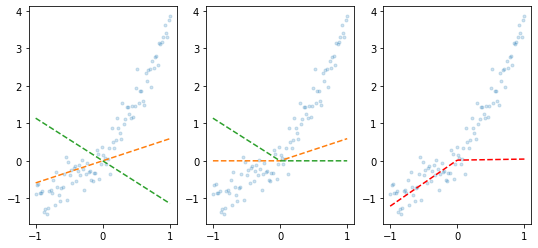

In [25]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3) 
fig.set_figwidth(9)
ax1.plot(x,y,'.',alpha=0.2); ax1.plot(x,l1(x),'--'); 
ax2.plot(x,y,'.',alpha=0.2); ax2.plot(x,a1(l1(x)),'--'); 
ax3.plot(x,y,'.',alpha=0.2); ax3.plot(x,l2(a1(l1(x))),'--r');

- 이런 그림이 100에폭마다 그려졌으면 좋겠다. 

첫번째는 원래 데이터 

`-` 새로운 클래스를 만들자. 

In [34]:
class PlotMidlayer(tf.keras.callbacks.Callback):
    def on_epoch_begin(self,epoch,logs): # 입력은 무조건 self, epoch, logs를 써야합니다 --> 이 함수안에 에폭이 끝날때마다 할 동작을 정의한다. 
        if epoch % 100 ==0: 
            fig, (ax1,ax2,ax3) = plt.subplots(1,3) 
            fig.set_figwidth(9)
            ax1.plot(x,y,'.',alpha=0.2); ax1.plot(x,l1(x),'--'); 
            ax2.plot(x,y,'.',alpha=0.2); ax2.plot(x,a1(l1(x)),'--'); 
            ax3.plot(x,y,'.',alpha=0.2); ax3.plot(x,l2(a1(l1(x))),'--r');            
            with tf.summary.create_file_writer(logdir).as_default():
                tf.summary.image("적합결과시각화"+str(epoch), plot_to_image(fig), step=0)

In [35]:
!rm -rf logs
cb1= tf.keras.callbacks.TensorBoard(update_freq='epoch',histogram_freq=100)
cb2= PlotMidlayer() 
net.fit(x,y,epochs=1000, batch_size=100,verbose=0 ,callbacks=[cb1,cb2])

In [38]:
# 
%tensorboard --logdir logs --host 0.0.0.0 

주황색은 힘을 발휘하지 못 해.. 렐루 만나면 0되고... 계속 축소되는 중

거의 초록색이 맞춘다!

-> 역할이 비슷하면 학습이 잘 안 된다.

안 되는 케이스

In [39]:
tf.random.set_seed(59) 
net = tf.keras.Sequential()
net.add(tf.keras.layers.Dense(2))
net.add(tf.keras.layers.Activation(tf.nn.relu))
net.add(tf.keras.layers.Dense(1))
net.compile(optimizer='sgd',loss='mse')
net.fit(x,y,epochs=1,batch_size=100)

1/1 [==============================] - 0s 122ms/step - loss: 2.1335


In [41]:
!rm -rf logs
cb1= tf.keras.callbacks.TensorBoard(update_freq='epoch',histogram_freq=100)
cb2= PlotMidlayer() 
net.fit(x,y,epochs=1000, batch_size=100,verbose=0 ,callbacks=[cb1,cb2])

In [42]:
# 
%tensorboard --logdir logs --host 0.0.0.0 

Reusing TensorBoard on port 6006 (pid 1492272), started 0:00:13 ago. (Use '!kill 1492272' to kill it.)